Implementing fully bayesian student's t process model from PYMC 5.X

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from pymc.gp.util import plot_gp_dist

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

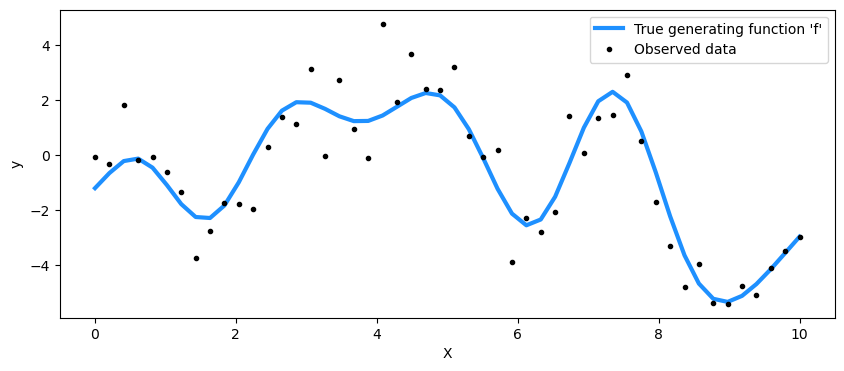

In [2]:
# generate some data to model

n = 50  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 4.0
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
f_true = pm.draw(pm.MvNormal.dist(mu=mean_func(X), cov=cov_func(X)), 1, random_seed=rng)

# the observed data is the mean function plus some t_distributed noise

sigma_true = 1.0
nu_true = 5.0
y = f_true+sigma_true * rng.standard_t(df=nu_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend(frameon=True);

In [3]:
with pm.Model() as TGP_model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov) # standard gaussian process

    f = gp.prior("f", X=X) # adds a mv norm prior over gp func vals

    sigma = pm.HalfNormal("sigma", sigma=2.0)
    nu = 1 + pm.Gamma("nu", alpha=2, beta=0.1) # nu must be >= 1

    y_ = pm.StudentT("y", mu=f, sigma=sigma, nu=nu, observed=y)

    trace = pm.sample(nuts_sampler='numpyro', chains=2)

# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(
    np.sum(az.rhat(trace)[["eta", "ell", "sigma", "f_rotated_"]].to_array() > 1.03).values
)
if n_nonconverged == 0:
    print("No Rhat values above 1.03, \N{check mark}")
else:
    print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

No Rhat values above 1.03, ✓


plot the model fit to the data

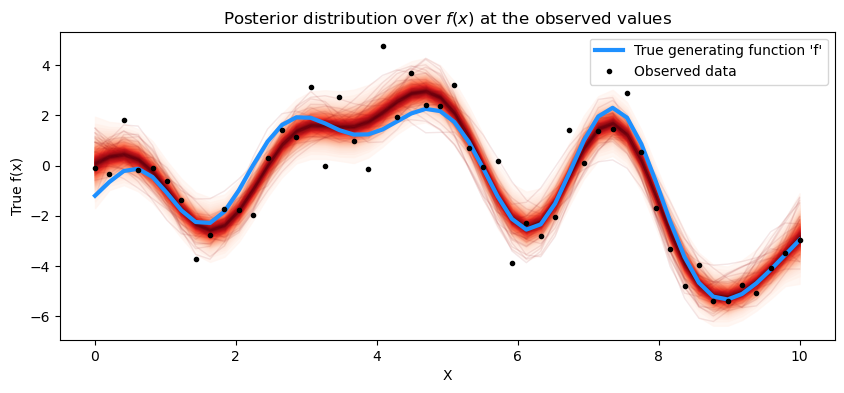

In [4]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_post = az.extract(trace, var_names="f").transpose("sample", ...)
plot_gp_dist(ax, f_post, X)

# plot the data and the true latent function
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

predict a new point

In [5]:
n_new = 1
X_new = np.array([1.3])[:, None]

with TGP_model:
    f_pred = gp.conditional("f_pred", X_new, jitter=1e-4)
    trace.extend(pm.sample_posterior_predictive(trace, var_names=["f_pred", "sigma", "nu"]))

Sampling: [f_pred, nu, sigma]


Output()

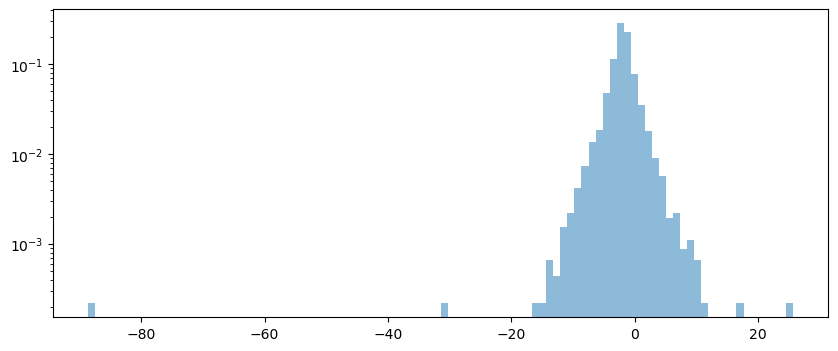

In [14]:
extract = az.extract(trace.posterior_predictive, var_names=["f_pred", "sigma", "nu"]).transpose("sample", ...)

f_pred = extract['f_pred'].values
sigma = extract['sigma'].values
nu = extract['nu'].values

def get_predictive_samples(mu_samples, sigma_samples, nu_samples):
    n_samples = mu_samples.shape[0]
    predictive_samples = np.empty((n_samples, n_new))

    for i in range(n_samples):
        predictive_samples[i] = np.random.standard_t(df=nu_samples[i], size=n_new) * sigma_samples[i] + mu_samples[i]

    return predictive_samples

samples = get_predictive_samples(f_pred, sigma, nu)

# plot the results
fig = plt.figure(figsize=(10, 4))
plt.hist(samples, bins=100, density=True, color="C0", alpha=0.5)
plt.yscale("log")
plt.show()


Now can we build a fully tp model?

In [42]:
import pymc as pm
import numpy as np

def build_tp_model(X, y=None):
    # Reshape X to be 2D
    X = X.reshape(-1, 1)

    with pm.Model() as model:
        # Hyperparameters
        nu = 2 + pm.Gamma("nu", mu=5, sigma=0.5)  # Degrees of freedom
        ls = pm.Gamma("lengthscale", mu=0.5, sigma=0.15)
        amp = pm.HalfNormal("amplitude", sigma=0.25)
        noise = pm.HalfNormal("noise", sigma=0.5)
        
        # Define kernel with diagonal noise
        cov_func = (
            amp**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls) + 
            pm.gp.cov.WhiteNoise(noise)
        )
        
        # Compute covariance matrix
        K = cov_func(X)
        
        # Student-t likelihood
        if y is not None:
            y_obs = pm.MvStudentT(
                "y_obs",
                nu=nu,
                mu=np.zeros(len(X)),
                scale=K,
                observed=y
            )
            
    return model

# Test with synthetic data
def generate_synthetic_data(n_points=50, noise_level=0.2):
    X = np.linspace(-3, 3, n_points)
    true_f = np.sin(X) + 0.3 * X**2
    noise = noise_level * np.random.standard_t(df=1, size=n_points)
    y = true_f + noise
    return X, y, true_f

# Quick test
X, y, true_f = generate_synthetic_data()
model = build_tp_model(X, y)



  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y_obs]


Output()


Model Verification Results:
nu_reasonable: PASS
noise_positive: PASS
lengthscale_reasonable: PASS

Posterior Parameter Estimates:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
nu           4.967  0.505   4.065    5.944      0.012    0.009    1768.0   
noise        0.096  0.029   0.046    0.152      0.001    0.001    1378.0   
lengthscale  0.966  0.158   0.663    1.256      0.004    0.003    1601.0   
amplitude    0.626  0.149   0.339    0.894      0.004    0.003    1381.0   

             ess_tail  r_hat  
nu             1220.0    1.0  
noise          1107.0    1.0  
lengthscale    1365.0    1.0  
amplitude       899.0    1.0  


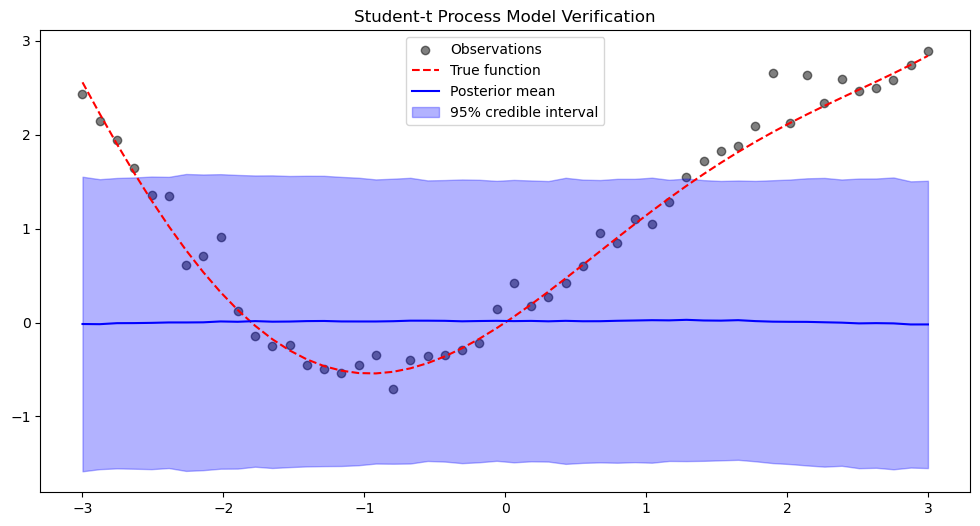

In [41]:
# 2. Model verification tests
def verify_tp_model():
    # Generate data
    X, y, true_f = generate_synthetic_data()
    
    # Fit model
    model = build_tp_model(X, y)
    
    with model:
        # Sample from posterior
        trace = pm.sample(1000, tune=1000, chains=2, nuts_sampler="numpyro")
        
    # Verification checks
    checks = {
        "nu_reasonable": trace.posterior["nu"].mean() > 2,  # nu should be > 2
        "noise_positive": trace.posterior["noise"].mean() > 0,
        "lengthscale_reasonable": 0 < trace.posterior["lengthscale"].mean() < 10
    }
    
    # Plot results
    plt.figure(figsize=(12, 6))
    
    # Plot data and true function
    plt.scatter(X, y, c='black', alpha=0.5, label='Observations')
    plt.plot(X, true_f, 'r--', label='True function')
    
    # Plot posterior predictive
    with model:
        y_post = pm.sample_posterior_predictive(
            trace, 
            var_names=["y_obs"],
        )
    
    # Calculate mean and credible intervals
    y_mean = y_post.posterior_predictive["y_obs"].mean(dim=["chain", "draw"])
    y_std = y_post.posterior_predictive["y_obs"].std(dim=["chain", "draw"])
    
    plt.plot(X, y_mean, 'b-', label='Posterior mean')
    plt.fill_between(X, 
                    y_mean - 2*y_std,
                    y_mean + 2*y_std,
                    alpha=0.3,
                    color='blue',
                    label='95% credible interval')
    
    plt.legend()
    plt.title('Student-t Process Model Verification')
    
    return checks, trace

# Run verification
checks, trace = verify_tp_model()

# Print diagnostics
print("\nModel Verification Results:")
for check_name, result in checks.items():
    print(f"{check_name}: {'PASS' if result else 'FAIL'}")

# Print posterior summaries
print("\nPosterior Parameter Estimates:")
print(pm.summary(trace, var_names=["nu", "noise", "lengthscale", "amplitude"]))

In [29]:
# with pm.Model() as tp_model:

#     ell = pm.Gamma("ell", alpha=2, beta=1)
#     eta = pm.HalfNormal("eta", sigma=5)

#     noise = pm.HalfNormal("noise", sigma=1.0)

#     cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
#     cov_comb = cov + pm.gp.cov.WhiteNoise(sigma=noise)

#     nu = pm.Gamma("nu", alpha=2, beta=1)
#     tp = pm.gp.TP(scale_func=cov_comb, nu=nu)
    



#     _y = pm.Deterministic("y", f, obs=y)

#     trace = pm.sample(nuts_sampler='numpyro', chains=2)

AttributeError: module 'pymc.gp' has no attribute 'Mar'